# 4.4 Downscaling Validation

After employing a method of statistical downscaling, such as DBCCA, it is important to perform some health checks and validation on the downscaled output, just like one would for the raw model data during the preliminary stages of analysis. However, since the downscaled results will be used to inform the rest of the climate impact study, the tests for agreement between the downscaled historical data and the observations need to be more stringent. Bias-correction and downscaling should bring historical GCM data to excellent agreement with observations for a similar time period. Otherwise, the chosen methods shouldn't be trusted to perform well for future, out-of-sample data.

In this notebook we will use some publicly available downscaled climate data from PCIC, downscaled using BCCAQv2, and the NRCan ANUSPLIN observations used as the training data for downscaling. We will perform some statistical tests to assess the agreement between the downscaled data and observations for the historical period, as well as some tests of significance for the climate change signal. 

As mentioned, the downscaled historical GCM data should be in near-perfect agreement with the observations for the reference period by construction. The most robust test would be to split the observations and historical simulations into training and validation periods. For example, we could calibrate our downscaling method using observations and historical simulation years from 1950-1980, apply this trained method to historical GCM simulations for 1981-2011, and then assess agreement with observations for 1981-2011. 

In their downscaling procedure, PCIC uses observations from 1950-2005. Unfortunately, this leaves only 12 years of *independent* observations for which the quality of downscaling can be assessed, since the NRCAN observations are only available until the year 2017. Really, it only leaves 9 independent years, since the CMIP6 historical simulations end in the year 2014 (after that, the SSP scenarios begin, and they don't have observed radiative forcing boundary conditions like the historical simulations do). Despite these limitations, we will demonstrate the validation methods using observations and GCM data for 1950-2005, and also for the 2006-2017 period, to demonstrate the training-validation split process.


Before getting into the tests, let's import the necessary libraries and access the data files from the PAVICS server. For simplicity, we will analyze data for only a small spatial region around Montreal.

For ease of reading, some code cells below are hidden by default. These cells simply import the necessary Python packages and access the datasets that will be used. The code cells can be revealed by clicking.

In [1]:
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

from siphon.catalog import TDSCatalog
from xclim.core.calendar import convert_calendar, percentile_doy
import xclim.indices as xci

# pysal.esda for spatial autocorrelation analysis
import esda 
import libpysal as lps

# URL for PAVICS' THREDDS server which hosts gridded observations and downscaled data
url_pavics = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/"
url_obs = url_pavics + "gridded_obs/catalog.xml"
url_downscaled = url_pavics + "simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/catalog.xml"

# centre of domain to analyze
lat_mtl = 45.5019
lon_mtl = -73.5674

# bounds of domain
lons = [lon_mtl - 1, lon_mtl + 1]
lats = [lat_mtl - 0.25, lat_mtl + 0.75]


/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/mike

In [2]:
# Create Catalog object - this contains the info for the datasets in this directory
cat_obs = TDSCatalog(url_obs)

# open the obs dataset and load the tasmax data
cds_obs = cat_obs.datasets[0] 
obs_ds = xr.open_dataset(cds_obs.access_urls["OPENDAP"])

# select and spatial domain
obs_ds = obs_ds.sel(lat = slice(*lats[::-1]), lon = slice(*lons))

# reverse latitude dimension to match model - with latitudes increasing with the index
obs_ds = obs_ds.isel(lat=slice(None, None, -1))

# select variable and time period, and convert units
variable_name = 'tasmin'
data_obs = obs_ds[variable_name] - 273.15
data_obs_train = data_obs.sel(time = obs_ds.time.dt.year.isin(range(1950, 2006))).load() 
data_obs_test = data_obs.sel(time = obs_ds.time.dt.year.isin(range(2006, 2018))).load() 


In [3]:
# same procedure for accessing model data
cat_sds = TDSCatalog(url_downscaled)

# open the gcm dataset and load the tasmax data
opendap_urls = [cat_sds.datasets[i].access_urls["OPENDAP"] for i in range(len(cat_sds.datasets))]
datasets_canesm = list(filter(lambda x: 'CanESM' in x, opendap_urls))

url_gcm = datasets_canesm[0] 
print(url_gcm)
gcm_ds = xr.open_dataset(url_gcm)
gcm_ds = gcm_ds.sel(lat = slice(*lats), lon = slice(*lons))

data_gcm = gcm_ds.tasmin
data_gcm_train = gcm_ds[variable_name].sel(time = gcm_ds.time.dt.year.isin(range(1950, 2006))).load() 
data_gcm_test = gcm_ds[variable_name].sel(time = gcm_ds.time.dt.year.isin(range(2006, 2018))).load() 

https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/day_BCCAQv2+ANUSPLIN300_CanESM5_historical+ssp585_r9i1p2f1_gn_1950-2100.ncml


In [4]:
# convert obs calendar to match model
data_obs_train = convert_calendar(data_obs_train, 'noleap')
data_obs_test = convert_calendar(data_obs_test, 'noleap')

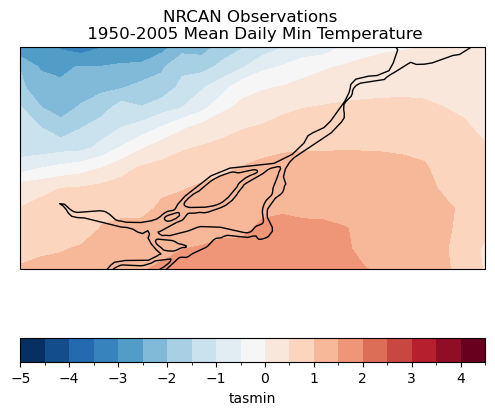

In [5]:
# plot the training sample long term means, just to compare quickly
data_mean_obs_train = data_obs_train.mean('time') 

fig, ax = plt.subplots(subplot_kw = spkws, figsize = (6,6))
data_mean_obs_train.plot.contourf(ax = ax, levels = np.arange(-5, 5, 0.5),
                                 cbar_kwargs = dict(orientation='horizontal', extendrect = True),
                                 zorder = 0)
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.coastlines()
ax.set_title("NRCAN Observations \n 1950-2005 Mean Daily Min Temperature")
plt.show()

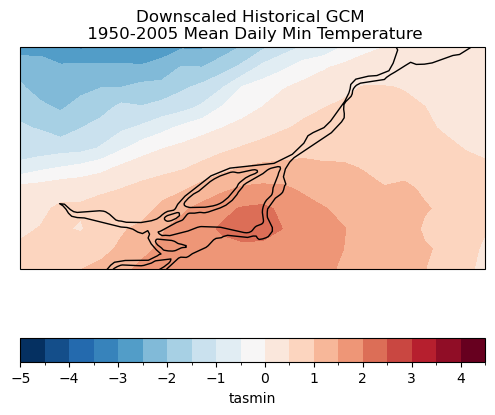

In [6]:
data_mean_gcm_train = data_gcm_train.mean('time') 

fig, ax = plt.subplots(subplot_kw = spkws, figsize = (6,6))
data_mean_gcm_train.plot.contourf(ax = ax, levels = np.arange(-5, 5, 0.5),
                                 cbar_kwargs = dict(orientation='horizontal', extendrect = True),
                                 zorder = 0)
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.coastlines()
ax.set_title("Downscaled Historical GCM \n 1950-2005 Mean Daily Min Temperature")
plt.show()

## 4.4.1 Distribution of Values

The first test we will perform is one that tests that the probability distribution of the downscaled historical data is consistent with that of the observations. The most appropriate statistical test for this purpose is the **two-sample Kolmogorov-Smirnov test**, often shortened to the [KS test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). This is a nonparametric test, so we don't need to make any assumptions of Gaussian statistics, as one does with the Student's $t$-test, for example.

The null hypothesis of the KS test is that the two sets of data being compared are generated from the same underlying probability distribution. For our purpose, we *want* the two distributions to be indistinguishable, so if we can reject the null hypothesis, this means the bias correction has not done its job well. The Scipy routine `ks_2samp` implements this test in Python and returns both the test statistic and the associated p-value (which is what we're more interested in). Let's run this test in the next notebook cell

In [7]:
# define a function that returns only the p-value, not the test statistic
get_ks_pval = lambda x,y: stats.ks_2samp(x, y).pvalue

# perform the test at each grid cell
ks_pvals_train = xr.apply_ufunc(get_ks_pval, 
                                # coordinate values are slightly mismatched, interp gcm to obs grid
                                data_gcm_train.interp(lat = data_obs_train.lat, 
                                                      lon = data_obs_train.lon),
                                data_obs_train,
                                input_core_dims = [['time'], ['time']], 
                                vectorize = True)

ks_pvals_test = xr.apply_ufunc(get_ks_pval, 
                               data_gcm_test.interp(lat = data_obs_test.lat, 
                                                    lon = data_obs_test.lon), 
                               data_obs_test,
                               input_core_dims = [['time'], ['time']], 
                               vectorize = True)

# mask where data is missing (if any)
ks_pvals_train = ks_pvals_train.where(~np.isnan(data_obs_train.isel(time=0)))
ks_pvals_test = ks_pvals_test.where(~np.isnan(data_obs_test.isel(time=0)))

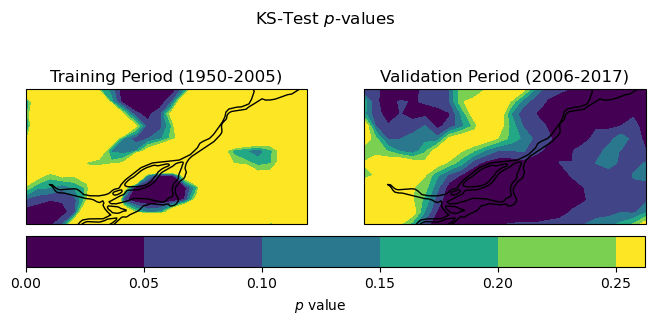

In [8]:
# plot
fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8,3))
fig.suptitle(r"KS-Test $p$-values")

p1 = ks_pvals_train.plot.contourf(ax = axes[0], levels = np.arange(0, 0.3, 0.05), add_colorbar = False)
axes[0].set_title("Training Period (1950-2005)")

p2 = ks_pvals_test.plot.contourf(ax = axes[1], levels = np.arange(0, 0.3, 0.05), add_colorbar = False)
axes[1].set_title("Validation Period (2006-2017)")

fig.colorbar(p1, ax = axes.ravel().tolist(), label = r"$p$ value", 
             orientation='horizontal', extendrect = True,
             pad = 0.05)
for ax in axes:
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.coastlines()

plt.show()

For the training period, the KS test p-values are mostly greater than the typical thresholds of 0.05 or 0.1 for rejecting the null hypothesis. This means for these locations we do not have sufficient evidence to say that the downscaled GCM data and the observations follow different probability distributions - which is good! This is not unexpected, since BCCAQv2 uses Quantile Delta Mapping for bias correction, and quantile mapping forces the distribution of the downscaled historical GCM data to match the observed distribution (as we saw in Section 4.2). However, it looks like there are some parts of the domain where the distributions are significantly different (according to the KS test) and even more regions in the validation period. Because we're looking at only a short time period, this could be a sampling issue, but it may also indicate some issues with the downscaling method. Assessing results for multiple methods of downscaling would be necessary to get an idea of the performance of one method relative to others.

## 4.4.2 Spatial Structure
The KS test assesses whether the distributions of the downscaled data at each location follows the same probability distribution as the observations. Passing this test does not guarantee that the observed spatial relationships of the data are preserved by the downscaling. In other words, we also need to assess if the *spatial autocorrelation* of the downscaled data agrees with the observations. The statistic we will use to measure the spatial autocorrelation is called [Moran's I](https://en.wikipedia.org/wiki/Moran%27s_I). This statistic is calculated with the formula:

$$
I = \frac{N}{W} \frac{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{ij} (x_{i} - \overline{x})(x_{j} - \overline{x}) } {\sum_{i=1}^{N}(x_{i} - \overline{x})^{2}}
$$

Where $x_{i}$ is the variable of interest $x$ at grid cell $i$, $N$ is the total number of grid cells, $w_{ij}$ are weights which describe the relative importance of variability at grid cell $i$ to the variability at grid cell $j$ - typically these weights are 1 for some $k$ nearest-neighbours and zero otherwise, or they can continuously decay with distance. We will use the $k = 8$ nearest neighbours (the 8 grid cells surrounding a given grid cell). $W$ is the sum of all weights $w_{ij}$. We'll use the Python library ``pysal.esda`` to calculate Moran's I.

Since this calculation is a bit slow running on a laptop, we'll only do it for the validation period, which is shorter. In practice, one should take the time to calculate this metric for both the training and validation periods (which would likely be much more feasible with better computational resources).

Since spatial autocorrelation does not include any temporal dependence, it is calculated for each timestep separately. When comparing the performance of different downscaling methods, {cite}`murdock_statistical_2014` downscaled *reanalysis* data, and compared the day-to-day variations of Moran's I for the downscaled reanalysis to the observed Moran's I. This is possible because reanalysis is designed to represent real-world sequencing. Since we are working with climate model output that has no relationship to the sequencing of real-world weather events, we'll instead compare the mean Moran's I for each of the two data products.

In [9]:
# construct a list of (lon, lat) tuples to use to construct the spatial weights
nlat = len(data_obs_train.lat)
nlon = len(data_obs_train.lon)
npts =  nlat * nlon

pts = []

for i in range(nlat):
    for j in range(nlon):
        pts += [(data_obs_train.lon[j], data_obs_train.lat[i])]
        


In [10]:
# construct the kNN weights (k=8)
k = 8
weights = lps.weights.KNN.from_array(pts, k)

In [11]:
# lambda function to use with xr.apply_ufunc, so we don't need to pass extra args
moran_I = lambda x: esda.Moran(x, weights).I

# calculate Moran's I for each timestep for the validation period.
moran_obs_test = xr.apply_ufunc(moran_I, data_obs_test,
                                input_core_dims = [['lat','lon']], 
                                output_dtypes = [float],
                                vectorize = True)

In [ ]:
moran_gcm_test = xr.apply_ufunc(moran_I, data_gcm_test,
                                input_core_dims = [['lat','lon']], 
                                output_dtypes = [float],
                                vectorize = True)

In [ ]:
# calculate mean and stdev's over time
moran_obs_test_mean = moran_obs_test.mean('time')
moran_gcm_test_mean = moran_gcm_test.mean('time')
moran_obs_test_std = moran_obs_test.std('time')
moran_gcm_test_std = moran_gcm_test.std('time')


print("Obs Moran I: %.2f" % moran_obs_test_mean.values, "+/- %.2f" % moran_obs_test_std.values)
print("Downscaled GCM Moran I: %.2f" % moran_gcm_test_mean.values, "+/- %.2f" % moran_gcm_test_std.values)

The mean Moran's I values for the observational data and the downscaled GCM data are consistent with each other, which is promising. The BCCA portion of the BCCAQv2 downscaling algorithm performs well at producing observed spatial structures in the downscaled data because it constructs the downscaled data using observed spatial patterns. The downscaled data shows slightly weaker spatial autocorrelation, perhaps because of the QDM step, which as discussed in the previous section, can degrade spatial structures. All in all, the two values are similar enough that there is no major cause for concern that the downscaled data is *poorly* representing the spatial autocorrelations of this climate variable.

## 4.4.3 Temporal Sequencing

In addition to spatial autocorrelations, we should also assess the quality with which the downscaled data captures observed temporal autocorrelations. The lag-$k$ autocorrelation for a time series $x(t)$ is defined as:

$$
r_{k} = \frac{\sum_{t = k+1}^{T} (x_{t} - \overline{x})(x_{t-k} - \overline{x})} {\sum_{t = 1}^{T} (x_{t} - \overline{x})^{2}}
$$

Here, $k$ is the lag in terms of the number of timesteps, but in climate science we often refer to lags in units of time (i.e. "lag 6-hour" autocorrelation).

We can calculate the autocorrelation using `np.correlate`, but this function is poorly named since it actually calculates the *autocovariance* which is not bounded between -1 and 1 like a true correlation is. To get the autocorrelation, we pass the de-meaned data to `np.correlate`, and then divide by the variance. Also, instead of subtracting the long-term time mean, we will subtract the climatological mean for each day of the year, so as to not inflate the autocorrelation because of the seasonal cycle.

In [ ]:
# subtract daily climatology to get daily anomalies
data_obs_test_mean = data_obs_test.groupby('time.dayofyear').mean('time')
data_obs_test_demeaned = data_obs_test.groupby('time.dayofyear') - data_obs_test_mean

# calculate variance and number of samples
var_obs_test = data_obs_test_demeaned.var('time')
ntime_obs_test = len(data_obs_test.time)



In [ ]:
autocov = lambda x: np.correlate(x,x,mode='same')
# calculate the numerator of the r_k expression
autocov_obs_test = dask.array.apply_along_axis(autocov, 
                                               data_obs_test_demeaned.get_axis_num('time'),
                                               data_obs_test_demeaned.data).compute()
# convert from a dask array to an xr.DataArray
autocov_obs_test = xr.zeros_like(data_obs_test) + autocov_obs_test

# re-name the 'time' dimension to 'lag' to reflect what the results represent, and assign lag values
autocov_obs_test = autocov_obs_test.rename({'time': 'lag'})
autocov_obs_test['lag'] = np.arange(-ntime_obs_test//2, ntime_obs_test//2, 1)

# now compute the autocorrelation from the autocovariance
autocor_obs_test = autocov_obs_test / (ntime_obs_test * var_obs_test)

To be certain our calculation has worked properly, let's select an arbitrary grid point, and plot the *autocorrelation function* for this grid cell, for lags of up to $\pm$90 days, which is the approximate length of an individual season.

In [ ]:
fig, ax = plt.subplots()
autocor_obs_test.isel(lat = 5, lon = 4).plot(ax = ax, marker = 'o')
ax.set_xlim(-90, 90)
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("lag (days)")
plt.show()

Everything looks good! The lag-zero autocorrelation is unity, which must be true since this is just the correlation of the data with itself. The curve rapidly decays for greater lags, which makes sense since the weather for a given day is likely to be similar to the weather for the days before and after, but shouldn't be strongly related to what happens dozens of days before or after.

The plot is symmetric about zero, which must also be true for the following reason: given a pair of days with day 1 coming N days before day 2, the lag-plus-N for day 1 is exactly the same as the lag-minus-N for day 2.

To look over the whole domain, let's plot maps of the autocorrelations for each grid cell in the domain, for lags of up to 10 days. Remember that since the autocorrelation is symmetric about zero, we only need to look at positive lags.

In [ ]:
fig, axes_array = plt.subplots(nrows = 2, ncols = 5, subplot_kw = spkws, figsize = (16, 5))
fig.suptitle("Observed Autocorrelations For Validation Period")
axes = axes_array.ravel()
for i in range(len(axes)):
    p = autocor_obs_test.sel(lag = i + 1).plot.contourf(ax = axes[i],
                                                        levels = 10, 
                                                        cbar_kwargs = {'label': None, 'shrink': 0.8})
                                                        
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].set_title(f"Lag {i+1} days")

plt.show()

Note that the colourbars for each plot are different because the autocorrelations decay with increasing lags. Next, we will make the same plots for the downscaled GCM data for the validation period.

In [ ]:
# do the same steps as for the obs autocorrelation, but for the downscaled GCM data
data_gcm_test_mean = data_gcm_test.groupby('time.dayofyear').mean('time')
data_gcm_test_demeaned = data_gcm_test.groupby('time.dayofyear') - data_gcm_test_mean

var_gcm_test = data_gcm_test_demeaned.var('time')
ntime_gcm_test = len(data_gcm_test.time)

autocov_gcm_test = dask.array.apply_along_axis(autocov, 
                                               data_gcm_test_demeaned.get_axis_num('time'),
                                               data_gcm_test_demeaned.data).compute()

autocov_gcm_test = xr.zeros_like(data_gcm_test) + autocov_gcm_test
autocov_gcm_test = autocov_gcm_test.rename({'time': 'lag'})
autocov_gcm_test['lag'] = np.arange(-ntime_gcm_test//2, ntime_gcm_test//2, 1)

autocor_gcm_test = autocov_gcm_test / (ntime_gcm_test * var_gcm_test)

In [ ]:
fig, ax = plt.subplots()
autocor_gcm_test.isel(lat = 5, lon = 4).plot(ax = ax, marker = 'o')
ax.set_xlim(-90, 90)
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("lag (days)")
plt.show()

In [ ]:
fig, axes_array = plt.subplots(nrows = 2, ncols = 5, subplot_kw = spkws, figsize = (16, 5))
fig.suptitle("Downscaled GCM Autocorrelations For Validation Period")
axes = axes_array.ravel()
for i in range(len(axes)):
    p = autocor_gcm_test.sel(lag = i + 1).plot.contourf(ax = axes[i],
                                                        levels = 10, 
                                                        cbar_kwargs = {'label': None, 'shrink': 0.8})
                                                        
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].set_title(f"Lag {i+1} days")

plt.show()

For lags up to 4 days, the downscaled GCM data shows similar autocorrelations to the observations. But as we can see from both the maps and the curve for the arbitrarily selected grid cell, the autocorrelations decay much faster for the GCM than the observations. So for timescales longer than a week or so (twice 4 days), the temporal sequencing of events in the downscaled GCM output may not be reliable. This might not be much of a problem if the climate indicator for your problem is based on annual aggregated totals (i.e. heating/cooling degree days, tropical nights, etc.), but it could be problematic for certain applications - this is where your own domain knowledge is important for assessing which sets of downscaled climate data suits your needs.

## 4.4.4 Extreme Indicators

Because of the effects extreme weather has on people and infrastructure, it is often the focus of climate change impact studies. Assessing the performance of downscaling methods to reproduce observed metrics/indicators of climate extremes is important. These tests also serve as independent measures of downscaling skill, because downscaling methods are not typically designed explicitly to perform well regarding extreme values {cite:p}`werner_hydrologic_2016`. The [Expert Team of Climate Change Detection and Indices](https://www.wcrp-climate.org/data-etccdi) (ETCCDI) has developed an extensive list of climate indices ([ClimDEX](https://www.climdex.org/learn/indices/)) that can be used for validation of downscaled climate data, as in {cite:t}`werner_hydrologic_2016`. 

Using our daily minimum temperature data, we will calculate two ClimDEX indices. Tropical Nights is a measure of extreme warm days and is defined as the number of days with daily minimum temperature above 20$^{\circ}$C. Even in the summer season, midlatitude nighttime temperatures do not often exceed this threshold, and when they do, there can be impacts on things like human comfort and air conditioning demand. 

In [ ]:
# assign units to all data, for use with xclim
data_obs_train.attrs['units'] = 'degC'
data_obs_test.attrs['units'] = 'degC'

data_gcm_train.attrs['units'] = 'degC'
data_gcm_test.attrs['units'] = 'degC'

# calculate Tropical Nights
tn_obs_train = xci.tn_days_above(data_obs_train)
tn_obs_test = xci.tn_days_above(data_obs_test)

tn_gcm_train = xci.tn_days_above(data_gcm_train)
tn_gcm_test = xci.tn_days_above(data_gcm_test)

Having calculated the number of Tropical Nights in each year for each dataset, let's plot maps of the long-term average annual Tropical Nights in the study region (click to reveal the code).

In [ ]:
# plot maps of average annual Tropical Nights
clevs_tn = np.arange(1, 15, 0.5)
fig, axes_array = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6), subplot_kw = spkws)
axes = axes_array.ravel()

tn_obs_train.mean('time').plot.contourf(ax = axes[0], levels = clevs_tn, add_colorbar = False)
axes[0].set_title("Observations (Training)")

tn_obs_test.mean('time').plot.contourf(ax = axes[1], levels = clevs_tn, add_colorbar = False)
axes[1].set_title("Observations (Validation)")

tn_gcm_train.mean('time').plot.contourf(ax = axes[2], levels = clevs_tn, add_colorbar = False)
axes[2].set_title("Downscaled GCM (Training)")

p = tn_gcm_test.mean('time').plot.contourf(ax = axes[3], levels = clevs_tn, add_colorbar = False)
axes[3].set_title("Downscaled GCM (Validation)")

fig.colorbar(p, ax = axes.tolist(), 
             extendrect = True,
             orientation = 'horizontal', 
             label = "Mean Annual Tropical Nights")

for ax in axes:
    ax.coastlines()
plt.show()

For the training period, the model seems to agree well with the observations regarding the typical number of tropical nights. For the validation period, the model significantly overestimates the frequency of tropical nights, which could be problematic for a study relating to changes to extreme high temperatures. 

Since the validation period is more recent, and there is a historical warming trend, this bias in Tropical Nights could be due to the high warming rate of CanESM5, the model we're working with for this example\*. This is an excellent demonstration of why even with downscaled data, it is often best to use a multi-model ensemble for climate change studies, to minimize the influence of issues particular to any given model.


```{note}
CanESM5 is known to have a higher Equilibrium Climate Sensitivity (ECS) than most other CMIP6 models. ECS is a measure of how much a climate model's global mean temperature changes when you double the concentration of CO$_{2}$, so a high ECS means a model will project a faster rate of warming {cite:p}`swart_canadian_2019`.
```


The next extreme indicator we will calculate is the Cold Spell Duration Index (CSDI). CSDI is the annual number of days in periods of at least 6 consecutive days below the 10th percentile for that day of the year. The 10th percentile is calculated for the baseline period 1961-1990, and for each day of the year, a 5-day window is used (i.e. the 10th percentile for March 10th is calculated using all days between March 8th-12th, for all years in 1961-1990). 

If CSDI sounds complicated to code, you aren't alone! We are very fortunate that `xclim` includes functions to do it for us. In the `xclim.indices` module, there are functions to compute many climate indices, including those from ClimDEX.

In [ ]:
# select obs and downscaled GCM data for the reference period
ref_yrs = range(1961, 1991) # remember Python ranges are not inclusive of the endpoint
data_obs_ref = data_obs_train.sel(time = data_obs_train.time.dt.year.isin(ref_yrs))
data_gcm_ref = data_gcm_train.sel(time = data_gcm_train.time.dt.year.isin(ref_yrs))

# calculate 10th percentile threshold
data_obs_10p = percentile_doy(data_obs_ref, per = 10).sel(percentiles = 10)
data_gcm_10p = percentile_doy(data_gcm_ref, per = 10).sel(percentiles = 10)

# calculate CSDI for train and test, obs and GCM
CSDI_obs_train = xci.cold_spell_duration_index(data_obs_train, data_obs_10p)
CSDI_obs_test = xci.cold_spell_duration_index(data_obs_test, data_obs_10p)

CSDI_gcm_train = xci.cold_spell_duration_index(data_gcm_train, data_gcm_10p)
CSDI_gcm_test = xci.cold_spell_duration_index(data_gcm_test, data_gcm_10p)

Now let's plot maps of annual mean Cold Spell Duration Index (click to reveal the code).

In [ ]:
# plot maps of annual CDSI
clevs_csdi = np.arange(0, 2, 0.05)
fig, axes_array = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6), subplot_kw = spkws)
axes = axes_array.ravel()

CSDI_obs_train.mean('time').plot.contourf(ax = axes[0], levels = clevs_csdi, add_colorbar = False)
axes[0].set_title("Observations (Training)")

CSDI_obs_test.mean('time').plot.contourf(ax = axes[1], levels = clevs_csdi, add_colorbar = False)
axes[1].set_title("Observations (Validation)")

CSDI_gcm_train.mean('time').plot.contourf(ax = axes[2], levels = clevs_csdi, add_colorbar = False)
axes[2].set_title("Downscaled GCM (Training)")

p = CSDI_gcm_test.mean('time').plot.contourf(ax = axes[3], levels = clevs_csdi, add_colorbar = False)
axes[3].set_title("Downscaled GCM (Validation)")

fig.colorbar(p, ax = axes.tolist(), 
             extendrect = True,
             orientation = 'horizontal', 
             label = "Mean Annual CSDI")

for ax in axes:
    ax.coastlines()

plt.show()

Interestingly, the downscaled data agrees better with the observations for the validation period, though it is likely that this is due to the historical warming trend - there will be fewer days below the 10th percentile of the reference period because the overall distribution of temperatures has shifted to higher values over time. 

For the training period, which overlaps completely with the baseline 1961-1990 period, the downscaled model output has more cold spells than observed. The overestimate of CSDI in the downscaled data would be important to keep under consideration for a study regarding changes to low temperatures. Again, a multi-model analysis may reveal that other models or a multi-model mean perform better at reproducing observed statistics for your metrics of interest. Choosing a range of models that represent the high and low ends of the distribution across models gives the best characterization of uncertainty due to modelling errors. There will be further discussion on model selection in Chapter 5.

Now that we've characterized our downscaled historical data as being in satisfactory agreement with observations, we can proceed to analyze the downscaled future projections. This will be the subject of the following section in this chapter.